In [13]:
path = r"..\results\llm_comparison\eac414135d4beaa2a3c24f16de77a4ba73ef222b9c99448e70552d4574f76b21\step_results.csv"

import pandas as pd
import numpy as np

df = pd.read_csv(path)
df

,step,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,time_elapsed,score,prompt
0,1,1375,490,157084,27202,113.610356,0.764147,Determine the appropriate category for the fol...
1,1,1375,490,157084,27202,113.610356,0.740891,Please read this news article carefully and as...
2,1,1375,490,157084,27202,113.610356,0.711822,Your task is to categorize the following news ...
3,1,1375,490,157084,27202,113.610356,0.696318,We're building a news classifier and need your...
4,1,1375,490,157084,27202,113.610356,0.683333,I'm working on a news classification project. ...
...,...,...,...,...,...,...,...,...
575,56,120602,65258,10107131,928668,61.267701,0.807171,I need to categorize news articles into four d...
576,56,120602,65258,10107131,928668,61.267701,0.806357,I need to classify news articles into four dis...
577,56,120602,65258,10107131,928668,61.267701,0.805310,Examine the given news article and determine i...
578,56,120602,65258,10107131,928668,61.267701,0.798953,I need to categorize news articles into four d...


In [22]:
# group df by step and get the mean of the values (ignore stings)
df_grouped = df.groupby("step").mean(numeric_only=True)
df_grouped

,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,time_elapsed,score
step,,,,,,
1,1375.0,490.0,157084.0,27202.0,113.207175,0.679341
2,2820.0,1074.0,815441.0,126094.0,251.506458,0.725136
3,4340.0,1680.0,882413.0,139501.0,36.787928,0.727558
4,6030.0,2510.0,1009512.0,158186.0,56.226584,0.737539
5,7601.0,3149.0,1121907.0,182451.0,52.509763,0.745473
6,9232.0,3915.0,1286002.0,204695.0,81.989677,0.755012
7,11043.0,4776.0,1351975.0,214248.0,34.572122,0.747345
8,12945.0,5804.0,1754070.0,237422.0,152.321862,0.778810
9,15242.0,7063.0,1945026.0,251267.0,80.041238,0.781318


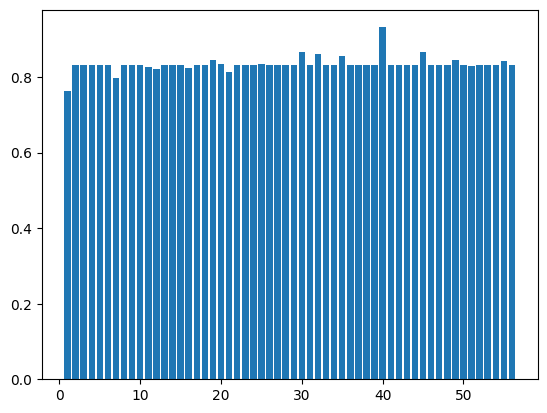

In [21]:
# plot token count vs step
import matplotlib.pyplot as plt

plt.bar(df["step"], df["score"]);